In [19]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
from scipy import stats
from itertools import combinations

Additional classes and functions

In [2]:
class PriorityQueue:
    """
    Priority queue data structure for shortest job first
    """
    def __init__(self):
        self.queue = []
    
    def push(self, item):
        self.queue.append(item)
        self._sift_up(len(self.queue) - 1)

    def pop(self):
        if len(self.queue) == 0:
            return None
        if len(self.queue) == 1:
            return self.queue.pop()
        
        top = self.queue[0]
        self.queue[0] = self.queue.pop()
        self._sift_down(0)
        return top

    def _sift_up(self, index):
        parent = (index - 1) // 2
        if parent >= 0 and self.queue[parent] > self.queue[index]:
            self.queue[parent], self.queue[index] = self.queue[index], self.queue[parent]
            self._sift_up(parent)

    def _sift_down(self, index):
        left_child = 2 * index + 1
        right_child = 2 * index + 2
        smallest = index

        if left_child < len(self.queue) and self.queue[left_child] < self.queue[smallest]:
            smallest = left_child
        if right_child < len(self.queue) and self.queue[right_child] < self.queue[smallest]:
            smallest = right_child

        if smallest != index:
            self.queue[index], self.queue[smallest] = self.queue[smallest], self.queue[index]
            self._sift_down(smallest)

    def get(self):
        return self.queue

def hyperexponential(cutoff, rate1, rate2):
    """Generates random number between 0 and 1 from hyperexponential distribution"""
    while True:
        random_number = random.random()  
        
        if random_number < cutoff:
            # generate from exp with rate=1 with probability 0.75
            return random.expovariate(rate1)
        else:
            # generate from exp with rate=1/5 with probability 0.25
            return random.expovariate(rate2)

def draw_random_number(distr, params):
    """ 
    Wraper function to perform random number generation
    using different distributions 

    exponential     : params = [ lambda ]
    pareto          : params = [ alpha ]
    lognormal       : params = [ mean, sigma ]
    hyperexponential: params = [ cutoff, rate1, rate2 ]
    """

    if isinstance(params, (int, float)):
        params = [params]
    elif isinstance(params, (str, dict)):
        raise 'TypeError: params must be of either of types: float, int, list, tuple'
    
    if distr == 'exponential':
        return random.expovariate(params[0])
    elif distr == 'pareto':
        return np.random.pareto(params[0])
    elif distr == 'lognormal':
        return np.random.lognormal(params[0], params[1])
    elif distr == 'hyperexponential':
        return hyperexponential(params[0], params[1], params[2])
    

def perform_shapiro_test(distribution):
    stat, p_value = stats.shapiro(distribution)
    return stat, p_value

def perform_priority_statistical_analysis(file_path):
    data = pd.read_csv(file_path)
    fifo_distributions = {}
    sjf_distributions = {}


    fifo_data = data[data['Method'] == 'FIFO']
    sjf_data = data[data['Method'] == 'SJF']

    for method_data, method_distributions in [(fifo_data, fifo_distributions), (sjf_data, sjf_distributions)]:
        for arrival_rate in method_data['Arrival_Rate'].unique():
            method_distributions[arrival_rate] = method_data[method_data['Arrival_Rate'] == arrival_rate]['Mean Waiting Time'].tolist()

    shapiro_results = {}
    mannwhitney_p_values = {}
    
 
    for method_name, distributions in [('FIFO', fifo_distributions), ('SJF', sjf_distributions)]:
        for arrival_rate, values in distributions.items():
            stat, p_value = perform_shapiro_test(values)
            shapiro_results[(method_name, arrival_rate)] = p_value

    for arrival_rate in fifo_distributions.keys():
        fifo_values = fifo_distributions[arrival_rate]
        sjf_values = sjf_distributions.get(arrival_rate, [])
        if sjf_values:
            u_statistic, p_value = stats.mannwhitneyu(fifo_values, sjf_values)
            mannwhitney_p_values[arrival_rate] = p_value
        else:
            print(f"No SJF data available for Arrival Rate {arrival_rate}")

    return {
        'Shapiro_Wilk_Results': shapiro_results,
        'Mann_Whitney_P_Values': mannwhitney_p_values
    }



Main code for queues

In [3]:
service_queue_lengths = [] 

class Queue:
    def __init__(self, env, arrival_rate, service_rate, num_servers, sjf = False):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.waiting_time_in_the_queue=[]
        self.service_queue = PriorityQueue() 
        
    def arrival(self, sjf = False):
        """The arrival process generates customers according to a Poisson process"""
        while True:
            ### Interarrival times follow exponential
            next_customer= random.expovariate(self.arrival_rate)
            ### Wait for the customer
            yield self.env.timeout(next_customer)  
            
            ### Start a service process
            self.env.process(self.service(sjf))

    def service(self, sjf = False):
        """The service process. The customer arrives and requests a service. The service time follows 
           the exponential distribution"""
        if sjf == False:
            with self.server.request() as req:
                queue_arrival_time= self.env.now
                yield req
                #### calculate waiting time
                waiting_time = self.env.now - queue_arrival_time
                
                service_time = random.expovariate(self.service_rate)
                yield self.env.timeout(service_time)
                
                self.waiting_time_in_the_queue.append(waiting_time)

        else:
            while True:
                yield self.env.timeout(0)  # release control to allow other processes to run
                with self.server.request() as req:
                    queue_arrival_time = self.env.now
                    service_time = random.expovariate(self.service_rate)
                    #### add customer to a service queue
                    self.service_queue.push((service_time, queue_arrival_time))

                    yield req
                    
                    #### track service queue length
                    service_queue_lengths.append(len(self.service_queue.get()))

                    #### if the current job is shortest - serve
                    shortest_job = self.service_queue.pop()
                    if shortest_job[1] == queue_arrival_time:
                        waiting_time = self.env.now - queue_arrival_time
                        yield self.env.timeout(shortest_job[0])
                        self.waiting_time_in_the_queue.append(waiting_time)

In [4]:
def run_simulations(arrival_rate, service_rate, sim_time, num_simulations, num_servers, full_output = False, sjf = False, stabilization_time = 0):
    """ will be later merged with setup_and_simulate() """
    all_mean_waiting_times= []
    
    for i in range(num_simulations):
        
        env = simpy.Environment()
        my_queue = Queue(env, arrival_rate, service_rate, num_servers)
        env.process(my_queue.arrival(sjf))
        env.run(until=sim_time)
        
        means = [] 
        
        for i in range(1, sim_time + 1):
            subset_data=my_queue.waiting_time_in_the_queue[:i]
            mean = np.mean(subset_data)
            means.append(mean)            
            
        all_mean_waiting_times.append(means)

    if full_output:
        return all_mean_waiting_times
    elif stabilization_time > 0:
        return all_mean_waiting_times[stabilization_time:]
    else:
        return np.mean(all_mean_waiting_times, axis=0), np.std(all_mean_waiting_times, axis=0)

In [5]:
def setup_and_simulate(arrival_rate, service_rate, sim_time, num_simulations, num_servers, stabilization_time = 0, sjf = False):
    means = []  
    for i in range(num_simulations):

            env = simpy.Environment()
            my_queue = Queue(env, arrival_rate, service_rate, num_servers)
            env.process(my_queue.arrival(sjf))
            env.run(until=sim_time)
            waiting_time = my_queue.waiting_time_in_the_queue[stabilization_time:]

            means.append(waiting_time)

    mean = [np.mean(lst, axis=0) for lst in means]
    return mean



Few diagnostic plots

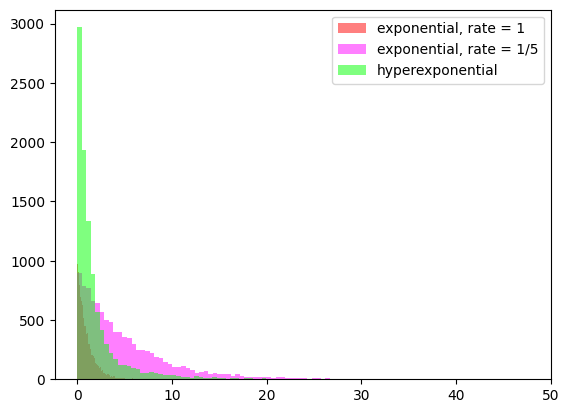

In [318]:
""" additional plot """

arr = []
for i in range(10000):
    arr.append(draw_random_number('exponential', [1]))
    
arr2 = []
for i in range(10000):
    arr2.append(draw_random_number('exponential', [1/5]))

arr3 = []
for i in range(10000):
    arr3.append(draw_random_number('hyperexponential', [0.75, 1, 1/5]))

plt.style.use('default')
plt.hist(arr, bins=100, fc=(1, 0, 0, 0.5), label='exponential, rate = 1')
plt.hist(arr2, bins=100, fc=(1, 0, 1, 0.5), label='exponential, rate = 1/5')
plt.hist(arr3, bins=100, fc=(0, 1, 0, 0.5), label='hyperexponential')
plt.legend()
plt.show()

Text(0, 0.5, 'service queue length')

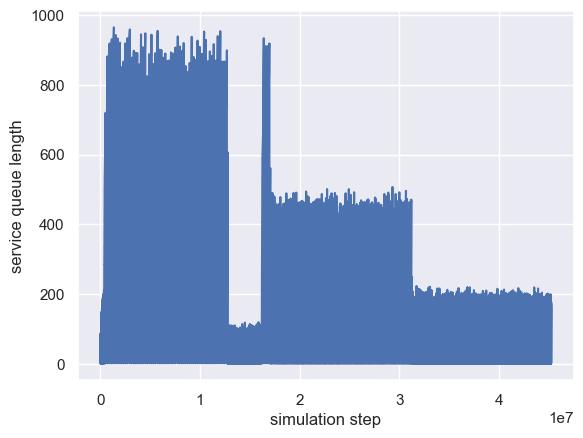

In [316]:
""" additional plot """

plt.plot(service_queue_lengths)
plt.xlabel('simulation step')
plt.ylabel('service queue length')

SJF dynamics

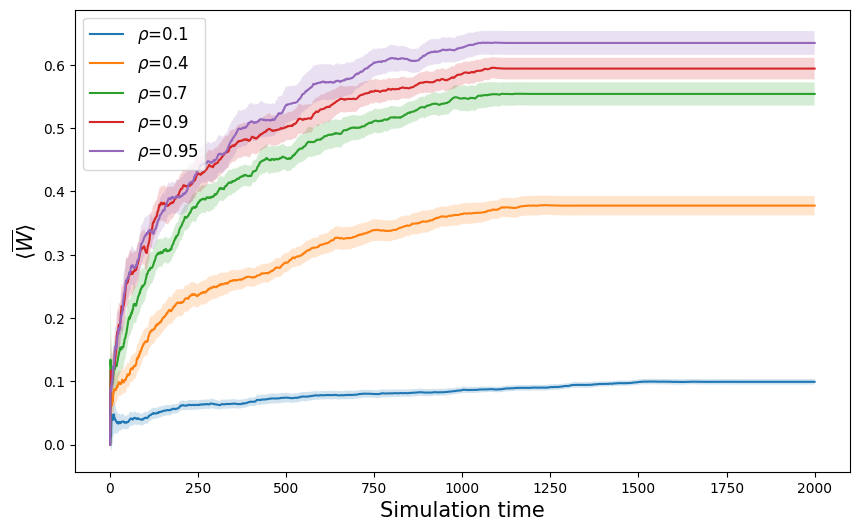

In [13]:
""" uncommented plot can be used in the report """

simulation_time = 2000
num_servers= 1
num_simulations = 50
service_rate = 1   # keep service rate the same, but vary arrival rate to get range of rho values

# plt.figure(figsize=(10, 6))

# sjf_flag = 0
# for arrival_rate in [0.1, 0.4, 0.7, 0.9, 0.95]:
#     means, st_devs= run_simulations(arrival_rate, service_rate, simulation_time, num_simulations,num_servers, sjf=sjf_flag)
#     confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
#     plt.plot(range(1, simulation_time +1), means, label=r'$\rho$=' + f'{arrival_rate}')
#     plt.fill_between(range(1, simulation_time +1), means+confid_int, means-confid_int, alpha=0.2)

#     # save results
#     data = zip(means, st_devs, confid_int)
#     file_name = f'data/vary_rho/sjf-{sjf_flag}_simtime{simulation_time}_rho{arrival_rate}_sims{num_simulations}.csv'
#     with open(file_name, 'w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(['Mean Waiting Time', 'Standard Deviation', 'Confidence Interval'])
#         for row in data:
#             writer.writerow(row)

# plt.ylabel(r'$\langle \overline{W} \rangle$')

# # plt.ylabel(r'$\langle \overline{W} \rangle$')
# plt.xlabel("Simulation time")
# plt.legend()
# plt.title(f"Waiting time over {num_simulations} simulations for a FIFO M/M/1 queue")


plt.style.use('default')
plt.figure(figsize=(10, 6))

sjf_flag = 1
for arrival_rate in [0.1, 0.4, 0.7, 0.9, 0.95]:
    means, st_devs= run_simulations(arrival_rate, service_rate, simulation_time, num_simulations,num_servers, sjf = sjf_flag)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    plt.plot(range(1, simulation_time +1), means, label=r'$\rho$=' + f'{arrival_rate}')
    plt.fill_between(range(1, simulation_time +1), means+confid_int, means-confid_int, alpha=0.2)

    # save results
    data = zip(means, st_devs, confid_int)
    file_name = f'data/vary_rho/sjf-{sjf_flag}_simtime{simulation_time}_rho{arrival_rate}_sims{num_simulations}.csv'
    with open(file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Mean Waiting Time', 'Standard Deviation', 'Confidence Interval'])
        for row in data:
            writer.writerow(row)

# plt.ylabel(r'$\mathbb{E}(W)$')
plt.ylabel(r'$\langle \overline{W} \rangle$', fontsize=15)

plt.xlabel("Simulation time", fontsize=15)
plt.legend(fontsize=12)
#plt.title(f"Waiting time over {num_simulations} simulations, for an SJF queue")


plt.savefig('plots/dynamics_for_rhos_sjf.png', dpi=300)
plt.show()


Defining number of simulations

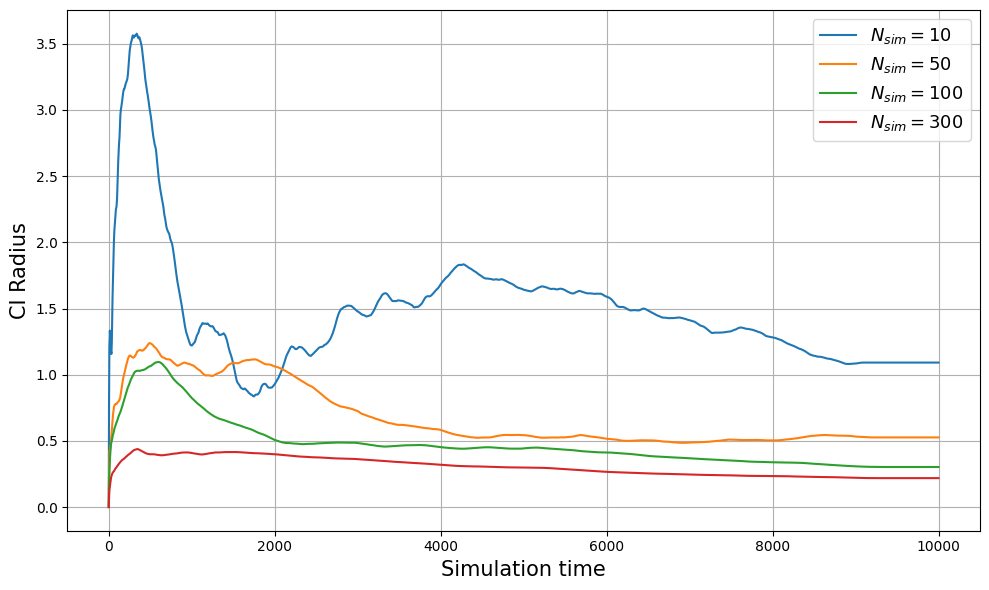

In [14]:

simulation_time = 10000
num_servers = 1
service_rate = 1
arrival_rate = 0.9  # so rho=0.9

sjf_flag = 0

plt.style.use('default')
plt.figure(figsize=(10, 6))

for num_simulations in [10, 50, 100, 300]:
    means, st_devs = run_simulations(arrival_rate, service_rate, simulation_time, num_simulations, num_servers, sjf=sjf_flag)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]

    plt.plot(range(1, simulation_time + 1), confid_int, label=r'$N_{sim}=$' + f'{num_simulations}')

plt.ylabel('CI Radius', fontsize=15)
plt.xlabel("Simulation time", fontsize=15)
plt.grid()
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig('plots/ci_radius_for_num_runs.png', dpi=300)
plt.show()

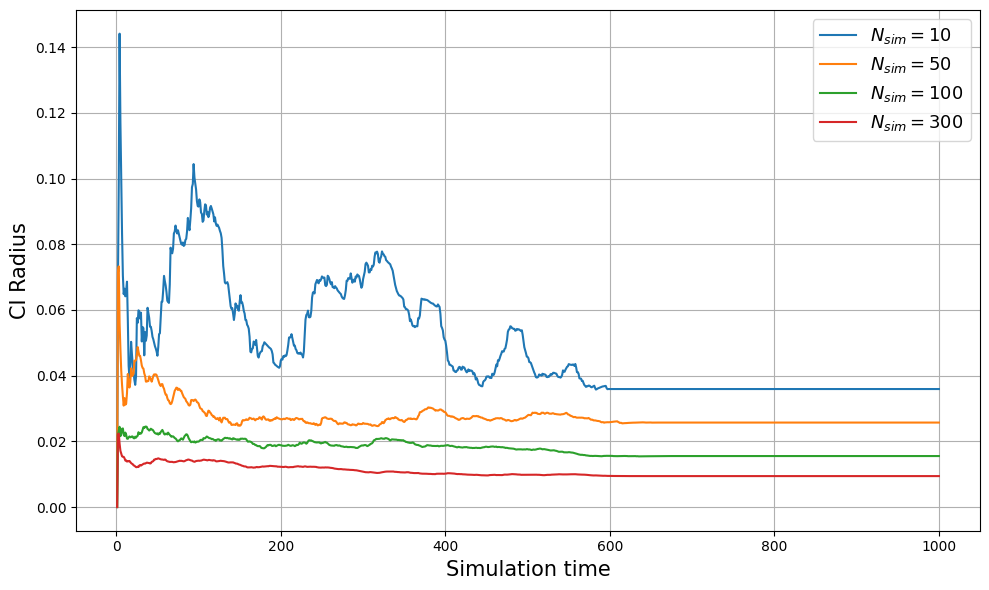

In [13]:
simulation_time = 1000
num_servers= 1
service_rate = 1
arrival_rate= 0.9  #so rho=0.9

sjf_flag = 1

plt.style.use('default')
plt.figure(figsize=(10, 6))

for num_simulations in [10, 50, 100, 300]:
    means, st_devs = run_simulations(arrival_rate, service_rate, simulation_time, num_simulations, num_servers, sjf=sjf_flag)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    plt.plot(range(1, simulation_time +1), confid_int, label=r'$N_{sim}=$' + f'{num_simulations}')

    # save results
    data = zip(means, st_devs, confid_int)
    file_name = f'data/vary_num_simulations/sjf-{sjf_flag}_simtime{simulation_time}_rho{arrival_rate}_sims{num_simulations}.csv'
    with open(file_name, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Mean Waiting Time', 'Standard Deviation', 'Confidence Interval'])
        for row in data:
            writer.writerow(row)

#plt.title('Simulations with different number of runs, SJF')
plt.ylabel("CI Radius", fontsize=15)
plt.xlabel("Simulation time", fontsize=15)
plt.legend(fontsize=13)
plt.tight_layout()
plt.grid()
plt.savefig('plots/ci_radius_for_num_runs_sjf.png', dpi=300)
plt.show()

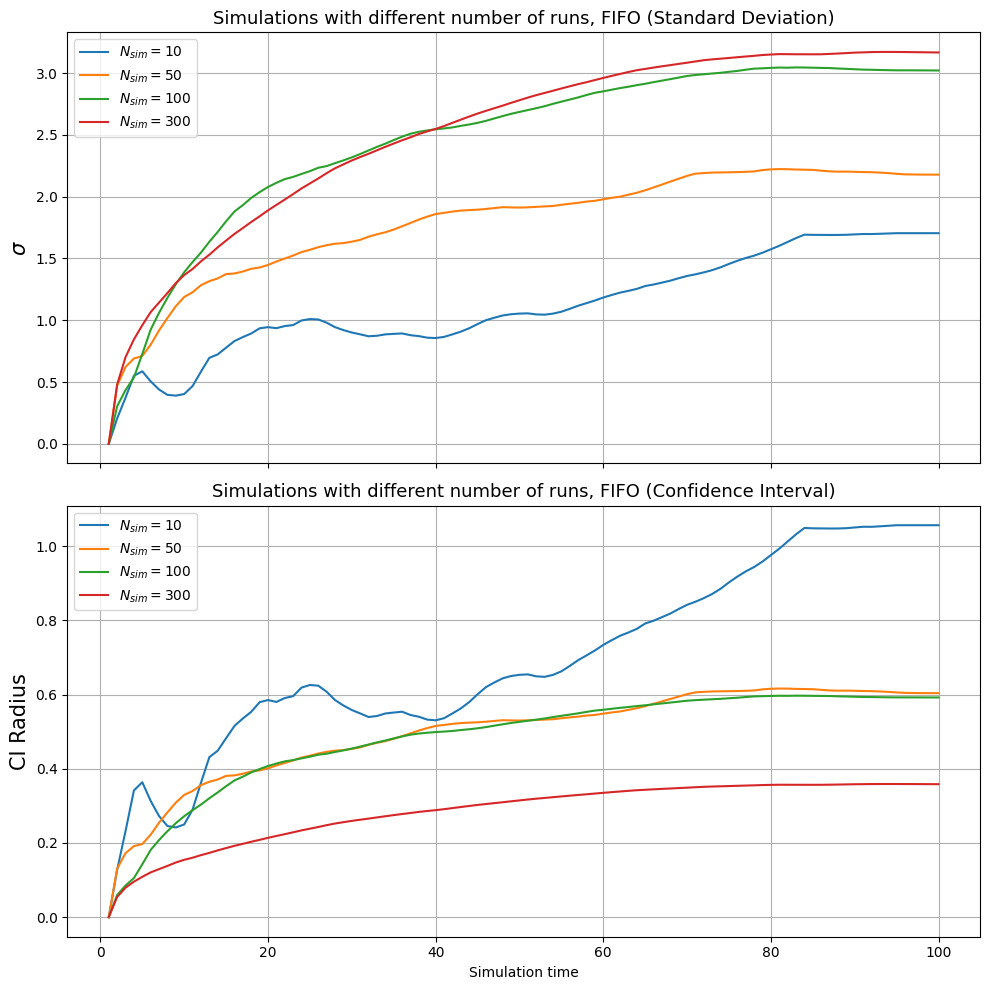

In [270]:
""" shows difference between std and CI, don't know if we need it """
simulation_time = 100
num_servers = 1
service_rate = 1
arrival_rate = 0.9  # so rho=0.9

sjf_flag = 0

plt.style.use('default')
fig, axs = plt.subplots(2, figsize=(10, 10), sharex=True)

for num_simulations in [10, 50, 100, 300]:
    means, st_devs = run_simulations(arrival_rate, service_rate, simulation_time, num_simulations, num_servers, sjf=sjf_flag)
    confid_int = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]

    axs[0].plot(range(1, simulation_time + 1), st_devs, label=r'$N_{sim}=$' + f'{num_simulations}')
    axs[1].plot(range(1, simulation_time + 1), confid_int, label=r'$N_{sim}=$' + f'{num_simulations}')

axs[0].set_title('Simulations with different number of runs, FIFO (Standard Deviation)', fontsize=13)
axs[0].set_ylabel('$\sigma$', fontsize=15)
axs[0].grid()
axs[1].set_title('Simulations with different number of runs, FIFO (Confidence Interval)', fontsize=13)
axs[1].set_ylabel('CI Radius', fontsize=15)
axs[1].grid()
plt.xlabel("Simulation time")

for ax in axs:
    ax.legend(fontsize=13)

plt.tight_layout()
plt.savefig('plots/variance_for_num_runs.png', dpi=300)
plt.show()

FIFO vs SJF statistical analysis

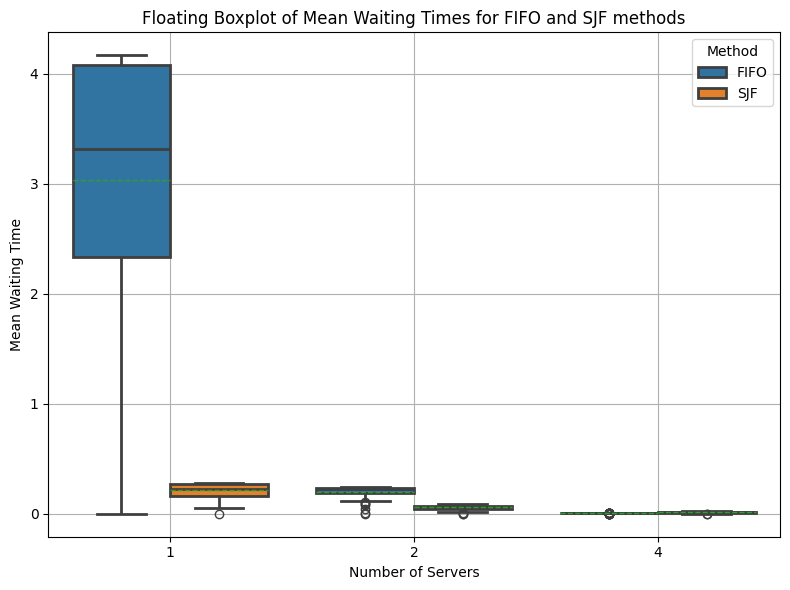

In [250]:
""" additional plot """

simulation_time = 100
num_simulations = 100
service_rate = 1   # keep service rate the same, but vary arrival rate to get range of rho values
arrival_rate = 0.9
num_servers = [1, 2, 4]

fifo_data = {}
sjf_data = {}
for server in num_servers:
    fifo_data[server] = run_simulations(arrival_rate, service_rate, simulation_time, num_simulations, server)[0]
    sjf_data[server] = run_simulations(arrival_rate, service_rate, simulation_time, num_simulations, server, sjf=True)[0]


# Formatting data into DataFrame for Seaborn
data = []
for method, method_data in [(method, method_data) for method, method_data in [('FIFO', fifo_data), ('SJF', sjf_data)]]:
    for num_servers, values in method_data.items():
        for value in values:
            data.append({'Method': method, 'Num_Servers': num_servers, 'Mean Waiting Time': value})

df = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Num_Servers', y='Mean Waiting Time', hue='Method', data=df, showmeans=True, meanline=True, linewidth=2)
plt.xlabel('Number of Servers')
plt.ylabel('Mean Waiting Time')
plt.title('Floating Boxplot of Mean Waiting Times for FIFO and SJF methods')
plt.legend(title='Method')
plt.grid(True)
plt.tight_layout()
plt.show()

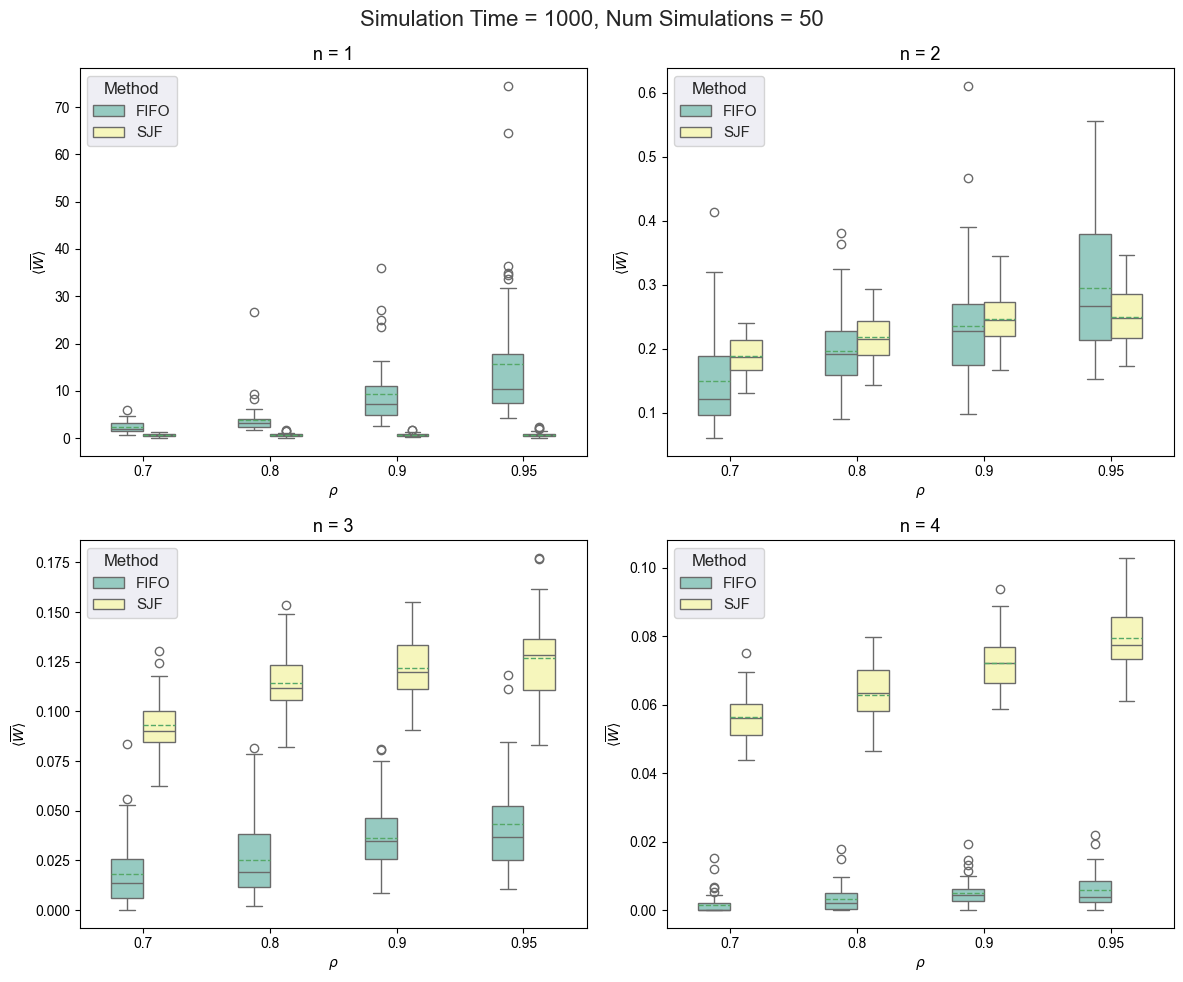

In [6]:
""" plot for final report (the next cell)"""

#### generally run for as big simulation_time as possible

simulation_time = 1000
stabilization_time = 500
num_simulations = 50
service_rate = 1
arrival_rates = [0.7, 0.8, 0.9, 0.95]
num_servers_list = [1, 2, 3, 4]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
sns.set(font_scale=1) 

for idx, num_servers in enumerate(num_servers_list):
    fifo_data = {}
    sjf_data = {}

    for rate in arrival_rates:
        fifo_data[rate] = setup_and_simulate(rate, service_rate, simulation_time, num_simulations, num_servers, stabilization_time=stabilization_time)
        sjf_data[rate] = setup_and_simulate(rate, service_rate, simulation_time, num_simulations, num_servers, stabilization_time=stabilization_time, sjf=True)

    data = []
    for method, method_data in [('FIFO', fifo_data), ('SJF', sjf_data)]:
        for rate, values in method_data.items():
            for value in values:
                data.append({'Method': method, 'Arrival_Rate': rate, 'Mean Waiting Time': value})

    df = pd.DataFrame(data)
    df.to_csv(f'data/priority_comparison/simtime{simulation_time}_numsims{num_simulations}_servers{num_servers}.csv', index=False)

    row = idx // 2
    col = idx % 2

    sns.boxplot(ax=axes[row, col], x=r'Arrival_Rate', y=r'Mean Waiting Time', hue='Method', data=df, showmeans=True, meanline=True, width=0.5, palette = "Set3")
    axes[row, col].set_title(f'n = {num_servers}', fontsize=13)
    axes[row, col].set_xlabel(r'$\rho$', fontsize=10)
    axes[row, col].set_ylabel(r'$\langle \overline{W} \rangle$', fontsize=10)
    axes[row, col].legend(title='Method')

plt.suptitle(f'Simulation Time = {simulation_time}, Num Simulations = {num_simulations}', fontsize=16)
plt.tight_layout()
#plt.savefig('plots/boxplot_priority_comparison.png', dpi=300)
plt.show()

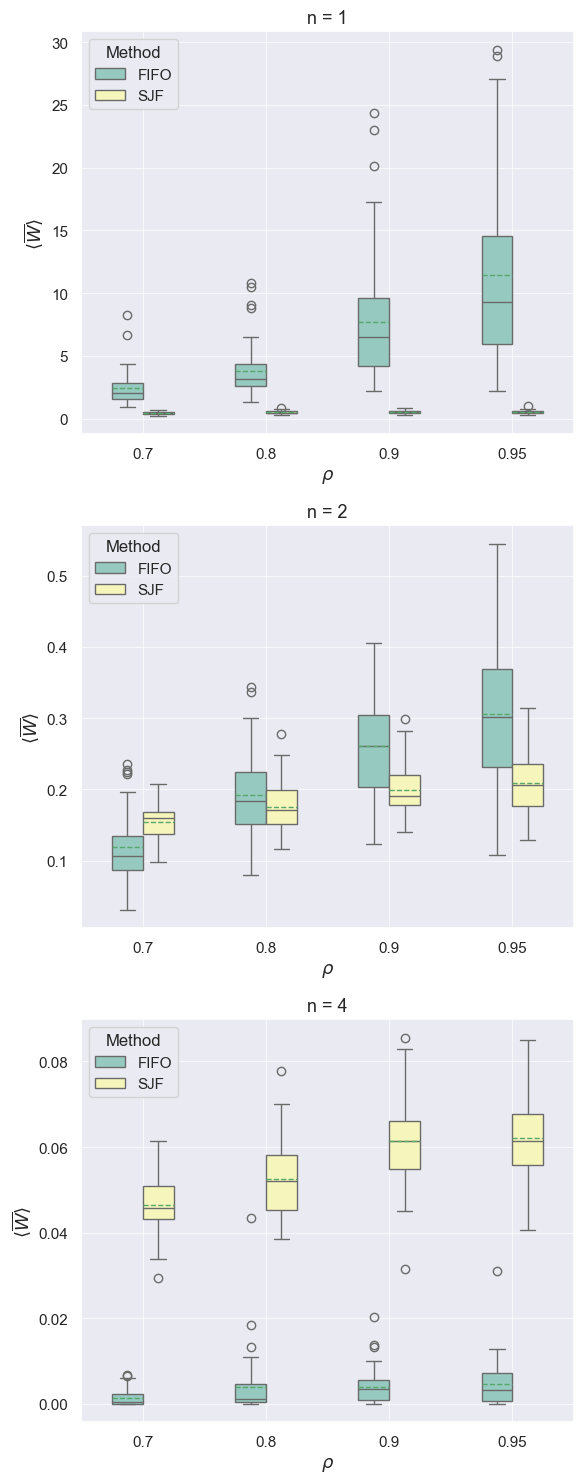

In [7]:
simulation_time = 1000
num_simulations = 500
num_servers_list = [1, 2, 4]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 15))
sns.set(font_scale=1)

for idx, num_servers in enumerate(num_servers_list): 

    df = pd.read_csv(f'data/priority_comparison/simtime500_numsims50_servers{num_servers}.csv')

    sns.boxplot(ax=axes[idx], x='Arrival_Rate', y='Mean Waiting Time', hue='Method',
                data=df, showmeans=True, meanline=True, width=0.5, palette="Set3")
    axes[idx].set_title(f'n = {num_servers}', fontsize=13)
    axes[idx].set_ylabel(r'$\langle \overline{W} \rangle$', fontsize=13)
    axes[idx].legend(title='Method')
    axes[idx].set_xlabel(r'$\rho$', fontsize=13)
    axes[idx].xaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')
    axes[idx].yaxis.grid(True, which='major', linestyle='-', linewidth=0.5, color='white')

plt.tight_layout()
plt.savefig('plots/boxplot_priority_comparison.png', dpi=300)
plt.show()

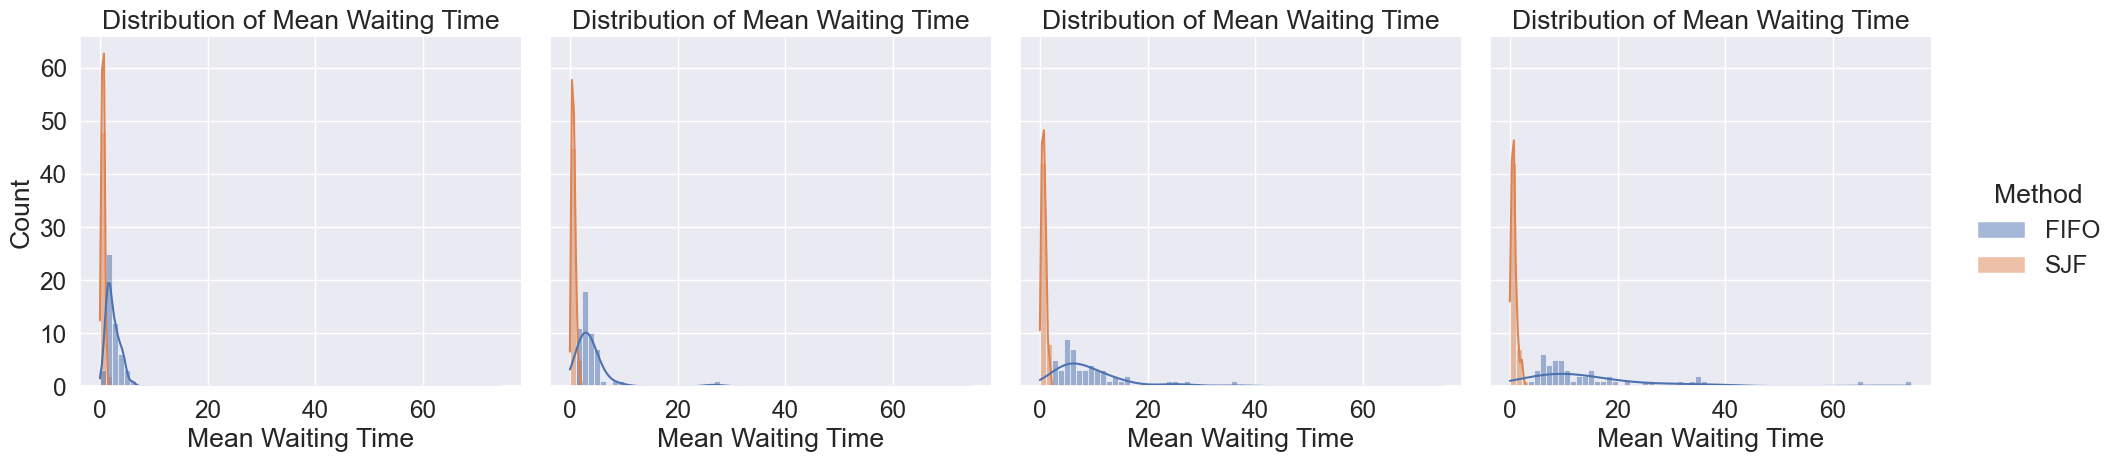

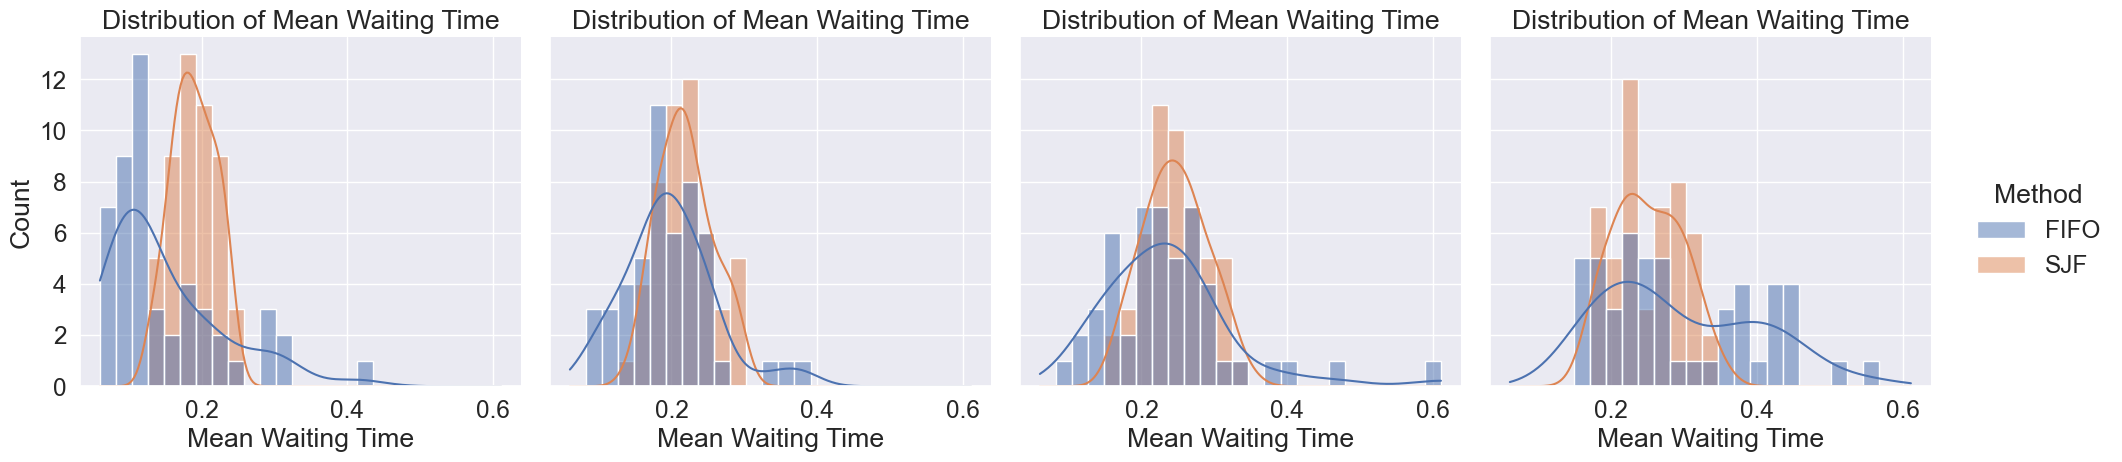

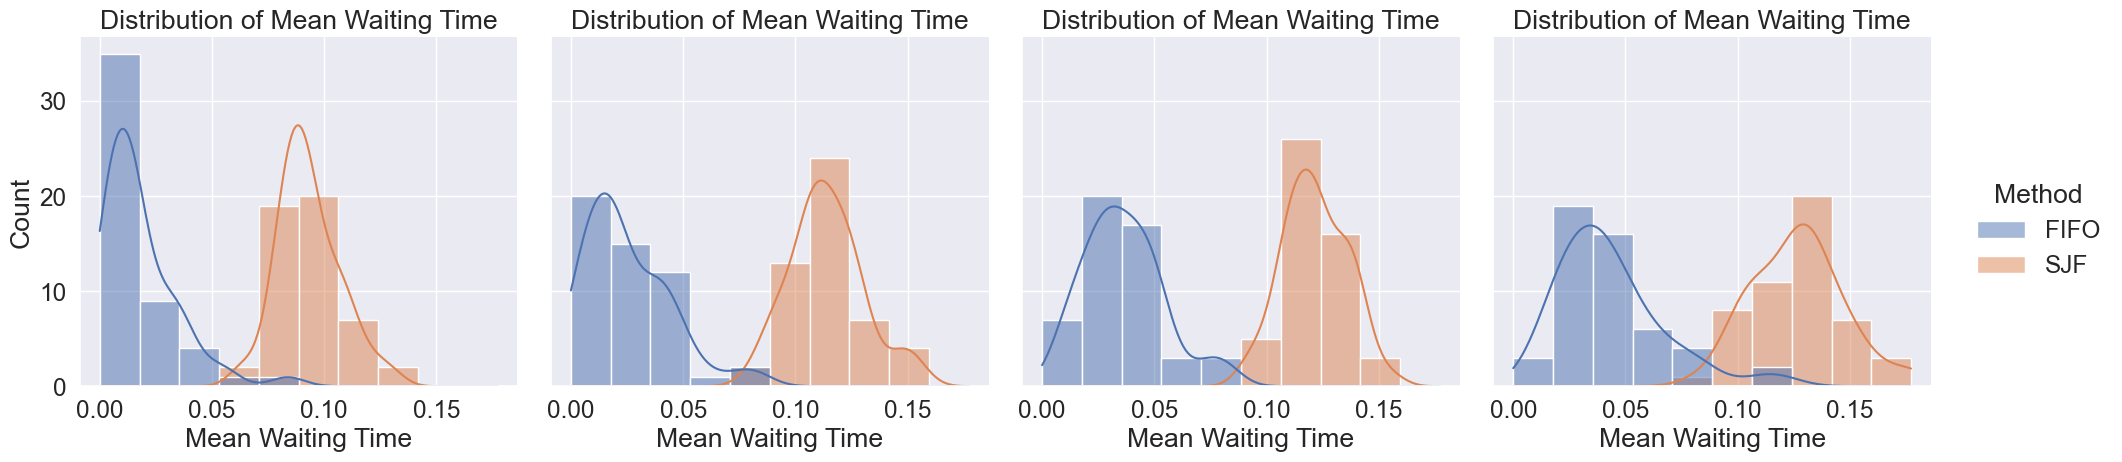

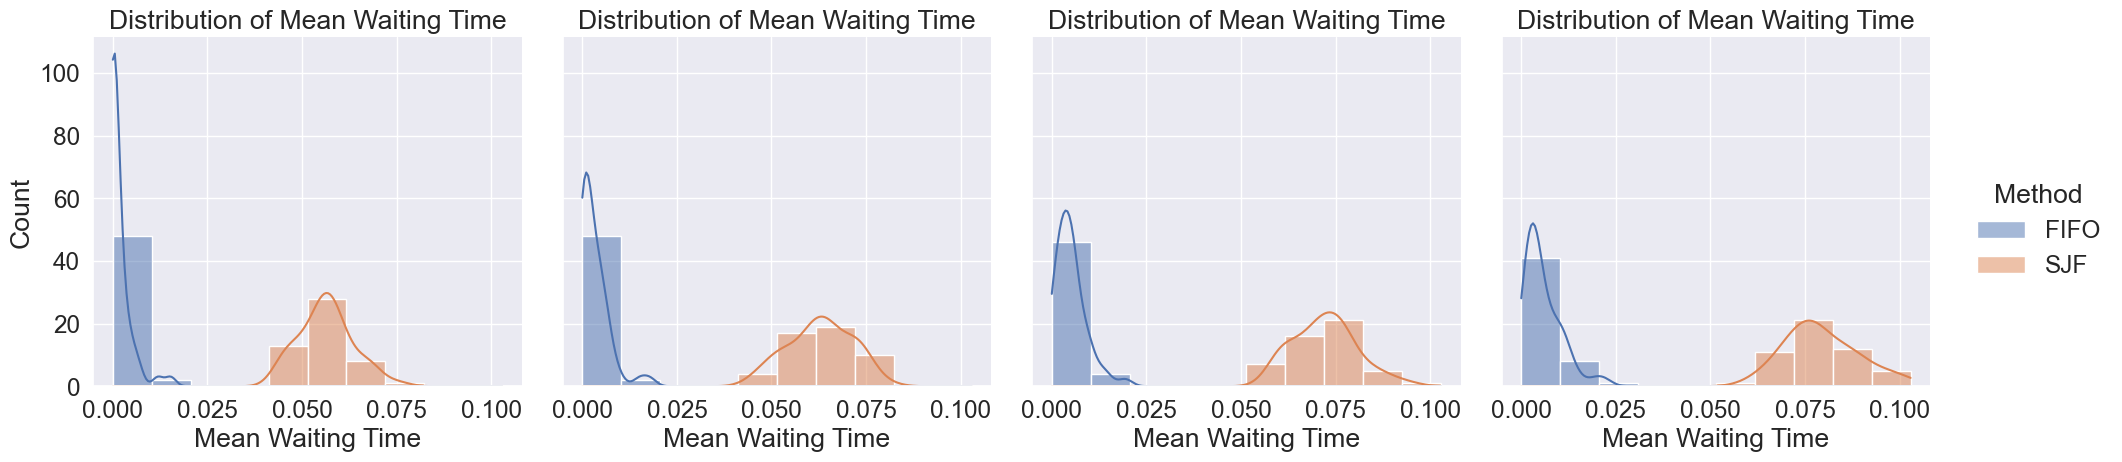

In [8]:
""" can be included in the report """

for i in range(1, 5):
    file_path = f'data/priority_comparison/simtime1000_numsims50_servers{i}.csv'
    data = pd.read_csv(file_path)

    sns.set(font_scale=1.6) 
    plot = sns.displot(data=data, x='Mean Waiting Time', col='Arrival_Rate', kde=True, hue='Method')
    plot.set(title='Distribution of Mean Waiting Time', xlabel='Mean Waiting Time', ylabel='Count')
    plt.savefig(f'plots/distributions_from_comparison_servers{i}.png', dpi=300)
    plt.show()
    sns.set(font_scale=1)

Statistical tests

In [9]:
file_path1 = f'data/priority_comparison/simtime1000_numsims50_servers{1}.csv'
file_path2 = f'data/priority_comparison/simtime1000_numsims50_servers{2}.csv'
file_path3 = f'data/priority_comparison/simtime1000_numsims50_servers{3}.csv'
file_path4 = f'data/priority_comparison/simtime1000_numsims50_servers{4}.csv'
results1 = perform_priority_statistical_analysis(file_path1)
results2 = perform_priority_statistical_analysis(file_path2)
results3 = perform_priority_statistical_analysis(file_path3)
results4 = perform_priority_statistical_analysis(file_path4)

In [10]:
print(results1['Shapiro_Wilk_Results'])
print(results2['Shapiro_Wilk_Results'])
print(results3['Shapiro_Wilk_Results'])
print(results4['Shapiro_Wilk_Results'])

{('FIFO', 0.7): 0.0032409222330898046, ('FIFO', 0.8): 3.3134590991107382e-12, ('FIFO', 0.9): 4.609817096934421e-07, ('FIFO', 0.95): 7.239342014742078e-09, ('SJF', 0.7): 0.7575834393501282, ('SJF', 0.8): 0.005325802136212587, ('SJF', 0.9): 0.037367817014455795, ('SJF', 0.95): 0.00020229234360158443}
{('FIFO', 0.7): 2.774207132461015e-05, ('FIFO', 0.8): 0.030119003728032112, ('FIFO', 0.9): 4.491709478315897e-05, ('FIFO', 0.95): 0.005713067017495632, ('SJF', 0.7): 0.3402393162250519, ('SJF', 0.8): 0.3196104168891907, ('SJF', 0.9): 0.6840071082115173, ('SJF', 0.95): 0.1987338662147522}
{('FIFO', 0.7): 3.7303593671822455e-06, ('FIFO', 0.8): 0.00035042065428569913, ('FIFO', 0.9): 0.04314001277089119, ('FIFO', 0.95): 0.0003647014091257006, ('SJF', 0.7): 0.23235784471035004, ('SJF', 0.8): 0.22589434683322906, ('SJF', 0.9): 0.8895098567008972, ('SJF', 0.95): 0.579178512096405}
{('FIFO', 0.7): 2.0093798847042876e-10, ('FIFO', 0.8): 3.477295820175641e-07, ('FIFO', 0.9): 0.0003677553031593561, ('F

In [11]:
print(results1['Mann_Whitney_P_Values'])
print(results2['Mann_Whitney_P_Values'])
print(results3['Mann_Whitney_P_Values'])
print(results4['Mann_Whitney_P_Values'])

{0.7: 1.2018654293015066e-16, 0.8: 8.461955518444686e-18, 0.9: 7.066071930388932e-18, 0.95: 7.066071930388932e-18}
{0.7: 2.8142900345746636e-05, 0.8: 0.013718901811779262, 0.9: 0.1015715141475768, 0.95: 0.12676571057376695}
{0.7: 1.4496003158260807e-17, 0.8: 7.066071930388932e-18, 0.9: 7.066071930388932e-18, 0.95: 4.4602443963843253e-17}
{0.7: 3.8948845372785926e-18, 0.8: 6.933396522207711e-18, 0.9: 7.064478413426748e-18, 0.95: 7.066071930388932e-18}


In [21]:
for i in range(1, 5):
    file_path = f'data/priority_comparison/simtime1000_numsims50_servers{i}.csv' 
    data = pd.read_csv(file_path)

    # Filter rows where Arrival_Rate is 0.9 and Method is 'SJF'
    filtered_data = data[(data['Arrival_Rate'] == 0.9) & (data['Method'] == 'SJF')]
    mean_waiting_times = filtered_data['Mean Waiting Time']

    mean = np.mean(mean_waiting_times)
    std_dev = np.std(mean_waiting_times)
    confidence_interval = stats.t.interval(0.95, len(mean_waiting_times) - 1, loc=mean, scale=stats.sem(mean_waiting_times))
    ci_radius = 1.96 * std_dev / np.sqrt(50)

    print(f'M/M/{i}/SJF')
    print(f"Mean: {mean}")
    print(f"Standard Deviation: {std_dev}")
    print(f"Confidence Interval: {confidence_interval}")
    print(f'CI radius: {ci_radius}')


M/M/1/SJF
Mean: 0.7341195085541753
Standard Deviation: 0.39059602232919677
Confidence Interval: (0.6219863523880684, 0.8462526647202822)
CI radius: 0.10826769366863911
M/M/2/SJF
Mean: 0.24674173784141387
Standard Deviation: 0.042773266515008186
Confidence Interval: (0.23446229540044716, 0.2590211802823806)
CI radius: 0.011856144588054616
M/M/3/SJF
Mean: 0.12167213784272715
Standard Deviation: 0.013908739522696618
Confidence Interval: (0.11767918663018824, 0.12566508905526608)
CI radius: 0.0038553059014284
M/M/4/SJF
Mean: 0.07221482751869776
Standard Deviation: 0.008153091641582715
Confidence Interval: (0.06987422022620553, 0.07455543481119)
CI radius: 0.0022599217038602112
